In [1]:
from google.colab import drive

drive.mount('/content/drive')

train_elephants = '/content/drive/MyDrive/data/train_elephants/'
train_zebras = '/content/drive/MyDrive/data/train_zebras/'
test = '/content/drive/MyDrive/data/test/'

Mounted at /content/drive


In [19]:
import torch, os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, v2

def load_images_with_labels(path, label):
  images = []
  labels = []

  transform = v2.Compose([
      v2.Resize(size = (64, 64)),
      v2.ToImage(),
      v2.ToDtype(torch.float32, scale = True)
  ])
  for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
      image_path = os.path.join(path, filename)
      try:

        image = PIL.Image.open(image_path).convert('RGB')
        image = transform(image)
        images.append(image)
        labels.append(label)
      except Exception as e:
        print(f"Error processing {image_path}: {e}")
  images_tensor = torch.stack(images)
  labels_tensor  = torch.tensor(labels)
  return images_tensor, labels_tensor

In [20]:
### convertir les listes en tenseurs torch
train_images_elephants, train_labels_elephants = load_images_with_labels(train_elephants, 0)
train_images_zebras, train_labels_zebras = load_images_with_labels(train_zebras, 1)

In [21]:
### fusionner les donneé torch.cat

train_images = torch.cat((train_images_elephants, train_images_zebras), dim = 0)
train_labels = torch.cat((train_labels_elephants, train_labels_zebras), dim = 0)

In [22]:
print(train_images.shape, train_labels.shape)

torch.Size([13999, 3, 64, 64]) torch.Size([13999])


In [23]:
train_images.dtype

torch.float32

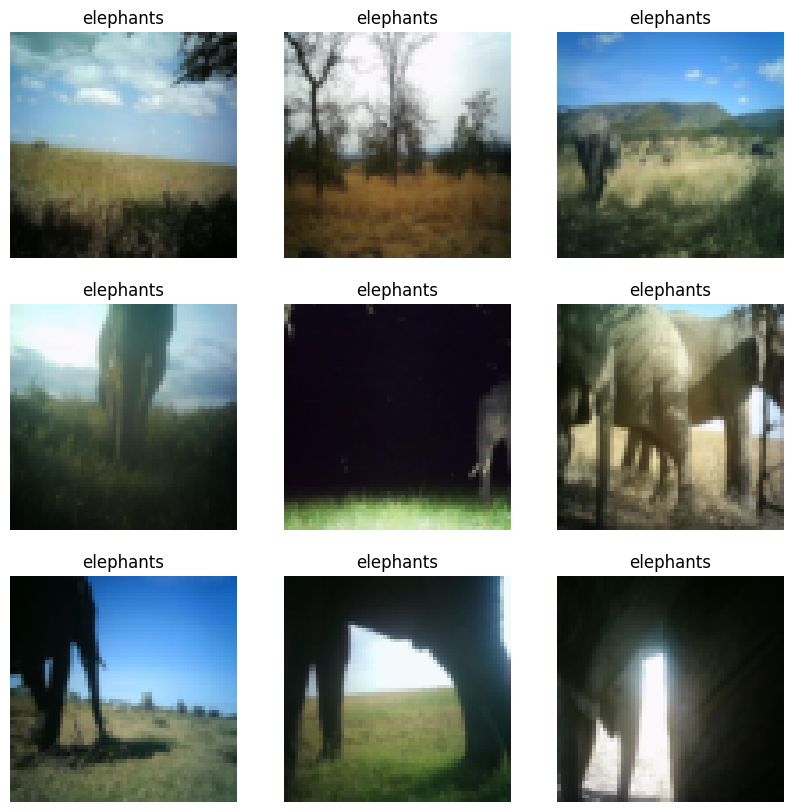

In [31]:
### visualisation de quelques images
torch.manual_seed(42)
plt.figure(figsize = (10, 10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(train_images[i].permute(1, 2, 0), cmap  = 'viridis')
  plt.axis('off')
  plt.title("elephants" if train_labels[i].item()==0 else "Zebres")
plt.show()

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [45]:
from sklearn.model_selection import train_test_split

Xtrain_images, Xval_images, ytrain_labels, yval_labels = train_test_split(train_images,
                                                                          train_labels,
                                                                          test_size = 0.2,
                                                                          random_state = 42)

In [46]:
Xtrain_images.shape, Xval_images.shape, ytrain_labels.shape, yval_labels.shape

(torch.Size([11199, 3, 64, 64]),
 torch.Size([2800, 3, 64, 64]),
 torch.Size([11199]),
 torch.Size([2800]))

In [51]:
### preparer les données avec dataloader
### encapulser les données en datasettensor (personnalisé)

from torch.utils.data import Dataset, DataLoader, TensorDataset

train_dataset = TensorDataset(Xtrain_images, ytrain_labels)
val_dataset = TensorDataset(Xval_images, yval_labels)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    shuffle = True
)

In [53]:
len(train_dataloader), len(test_dataloader)

(350, 88)

In [36]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 18.8 MB/s eta 0:00:00


In [68]:
###Buildng model
#!pip install torchinfo
from torch import nn
from torchmetrics import Accuracy
from torchinfo import summary

class ModelV1(torch.nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    ### block 1

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, padding = 1, kernel_size = 3, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 16 * 16, out_features = output_shape)
    )
  def forward(self, x:torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

modelv1 = ModelV1(input_shape = 3, hidden_units = 16, output_shape = 1).to(device)
modelv1.to(device)

ModelV1(
  (block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
  )
)

In [69]:
modelv1.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[-0.0422,  0.0388, -0.0937],
                        [ 0.1130,  0.1697, -0.1412],
                        [ 0.1673,  0.0360,  0.1422]],
              
                       [[ 0.0261,  0.0928, -0.0272],
                        [ 0.1484,  0.0284, -0.0898],
                        [ 0.0491, -0.0887, -0.0226]],
              
                       [[-0.0782,  0.1277, -0.1519],
                        [-0.0887, -0.0543, -0.1157],
                        [ 0.0182, -0.1901,  0.1738]]],
              
              
                      [[[-0.1635,  0.1486,  0.0320],
                        [-0.0625,  0.1189,  0.0300],
                        [ 0.1555,  0.0210, -0.0607]],
              
                       [[ 0.0517, -0.0522,  0.0810],
                        [ 0.1718,  0.1112, -0.0841],
                        [ 0.1111,  0.0344,  0.0977]],
              
                       [[-0.1173, -0.1905, -0.0744],
                      

In [70]:
### function de perte et d'optimization

### perte
loss_function = torch.nn.BCEWithLogitsLoss()

### optimiseur
optimizer = torch.optim.Adam(params = modelv1.parameters(), lr = 0.001)

In [71]:
accuracy = Accuracy(task = 'binary').to(device)

In [81]:
### function training and testing loop
torch.manual_seed(42)
def train_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               accuracy_fn,
               optimizer: torch.optim.Optimizer):

  train_loss, train_acc = 0, 0
  model.train()
  for batch, (xtrain, ytrain) in enumerate(dataloader):
    xtrain, ytrain = xtrain.to(device), ytrain.to(device)

    y_pred_train = model(xtrain)
    ### perte
    loss_train = loss_function(ytrain.float(), y_pred_train.squeeze(1))
    acc= accuracy_fn(ytrain, y_pred_train.argmax(dim = 1))
    train_loss +=loss_train.item()
    train_acc +=acc.item()

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  train_loss /=len(dataloader)
  train_acc /=len(dataloader)
  return train_loss, train_acc
  print(f"Train loss: {train_loss: .4f} | Train accuracy: {train_acc: .4f}")


### testing loop

def testing_loop(model: torch.nn.Module,
                 data_loader: torch.utils.data.DataLoader,
                 loss_function: torch.nn.Module,
                 accuracy_fn,
                 optimizer: torch.optim.Optimizer):

  test_loss, test_ac = 0, 0

  model.eval()
  with torch.inference_mode():
    for xtest, ytest in data_loader:
      xtest, ytest = xtest.to(device), ytest.to(device)
      ### pred test
      y_pred_test = model(xtest)

      loss_test = loss_function(ytest, y_pred_test.squeeze(1))
      acc = accuracy_fn(ytest, y_pred_test.argmax(dim = 1))
      test_loss +=loss_test.item()
      test_ac +=acc.item()
    test_loss /=len(data_loader)
  test_ac /=len(data_loader)
  return test_loss, test_ac
  print(f"Test loss: {test_loss: .4f} | Test accuracy: {test_ac: .4f}")

In [84]:
torch.manual_seed(42)
from tqdm.auto import tqdm

epochs = 5
for epoch in tqdm(range(epochs)):
  train_loop(model = modelv1,
                                     dataloader = train_dataloader,
                                     loss_function = loss_function,
                                     accuracy_fn = accuracy,
                                     optimizer = optimizer)
  testing_loop(model = modelv1,
                                     data_loader = test_dataloader,
                                     loss_function = loss_function,
                                     accuracy_fn = accuracy,
                                     optimizer = optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: "log_sigmoid_cpu" not implemented for 'Long'